# Setup

In [59]:
# Add parent directory to current path. Needed for research imports.
import os.path
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)

# Enable hot reloading
%load_ext autoreload
%autoreload 2


import datetime
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from experiments.irl.fair_irl import *
from imblearn.under_sampling import RandomUnderSampler
from research.irl.fair_irl import *
from research.ml.svm import SVM
from research.utils import *
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold


logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

cp = sns.color_palette()
sns.set_style('darkgrid')

from IPython.display import display, HTML
display(HTML("<style>.container { width:1800px !important; }</style>"))
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set Parameters

In [60]:
from fairlearn.reductions import DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer


class ReductionWrapper():
    def __init__(self, clf, sensitive_features):
        self.clf = clf
        self.sensitive_features = sensitive_features
    
    def fit(self, X, y, sample_weight=None, **kwargs):
        self.clf.fit(
            X,
            y,
            sensitive_features=X[self.sensitive_features],
            **kwargs,
        )
        return self
    
    def predict(self, X, sample_weight=None, **kwargs):
        return self.clf.predict(
            X,
            sensitive_features=X[self.sensitive_features],
            **kwargs,
        )


In [73]:
##
# Objective set - the fairness metrics to consider.
##
obj_set = ObjectiveSet([
    AccuracyObjective(),
    DisparateImpactObjective(),
    EqualOpportunityObjective(),
])

##
# Expert demonstration parameters
##
N_EXPERT_DEMOS = 3
EXPERT_ALGO = 'HardtDisImp'
# These are the feature types that will be used in the classifier that will
# produce the expert feature demonstrations.
expert_demo_feature_types = {
    'boolean': [
        'z',
    ],
    'categoric': [
        'workclass',
        'education',
        # 'marital-status',
        # 'occupation',
        # 'relationship',
        # 'native-country',
        # 'race',
          'sex',
    ],
    'continuous': [
        # 'age',
        # 'educational-num',
        # 'capital-gain',
        # 'capital-loss',
        # 'hours-per-week',
    ],
    'meta': [
        'fnlwgt'
    ],
}
# These are the feature types that will be used in the classifier that will
# predict `y` given `X` when learning the optimal policy for a given reward
# function.
irl_loop_feature_types = expert_demo_feature_types
pipe = sklearn_clf_pipeline(
    feature_types=expert_demo_feature_types,
#     clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
    clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
)
dem_par_clf = ThresholdOptimizer(
    estimator=pipe,
    constraints='demographic_parity',
    predict_method="predict",
    prefit=False,
)
dem_par_reduction = ReductionWrapper(
    clf=dem_par_clf,
    sensitive_features='z',
)
pipe = sklearn_clf_pipeline(
    feature_types=expert_demo_feature_types,
#     clf_inst=RandomForestClassifier(),  # For some resaon, using a RF here prevents the ThresholdOptimizer from obtaining a decent value on Demographic Parity
    clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
)
eq_opp_clf = ThresholdOptimizer(
    estimator=pipe,
    constraints='true_positive_rate_parity',
    predict_method="predict",
    prefit=False,
)
eq_opp_reduction = ReductionWrapper(
    clf=eq_opp_clf,
    sensitive_features='z',
)

EXPERT_ALGO_LOOKUP = {
    'OptAcc': sklearn_clf_pipeline(expert_demo_feature_types, RandomForestClassifier()),
    'pos_pred_to_female_only': ManualClassifier(lambda row: int(row['gender'] == 'Female')),
    'HardtDisImp': dem_par_reduction,
    'HardtEqOpp': eq_opp_reduction,
}


N_TRIALS = 3
##
# IRL loop parameters
##
IRL_METHOD = 'FairIRL'
N_INIT_POLICIES = 1
NO_NEG_WEIGHTS = False
SAMPLE_LEARNED_POLICIES = False
RANDOM_WEIGHT_RATE = 0
SKIP_ERROR_TERMS = True
METHOD = 'highs'
epsilon = .01
max_iter = 5

if IRL_METHOD == 'FairIRL':
    CAN_OBSERVE_Y = False
elif IRL_METHOD == 'FairIRLFO':
    CAN_OBSERVE_Y = True
##
# Plotting parameters
##
ANNOTATE = True
NOISE_FACTOR = .02

In [74]:
trial_info = {
    'objective_names': [obj.name for obj in obj_set.objectives],
    'N_EXPERT_DEMOS': N_EXPERT_DEMOS,
    'EXPERT_ALGO': EXPERT_ALGO,
    'expert_demo_feature_types': expert_demo_feature_types,
    'irl_loop_feature_types': irl_loop_feature_types,
    'N_TRIALS': N_TRIALS,
    'IRL_METHOD': IRL_METHOD,
    'N_INIT_POLICIES': N_INIT_POLICIES,
    'epsilon': epsilon,
    'max_iter': max_iter,
}

# Execute

INFO:root:

TRIAL 0

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3651  0.149548
	1  21349  0.255188

INFO:root:muE:
[[0.64176317 0.79790811 0.9373814 ]
 [0.64475159 0.79977587 0.93550996]
 [0.65035487 0.79342548 0.94112375]]
INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.27754949570414644
INFO:root:Expert demo yhat:	 0.2786701531565185
INFO:root:Expert demo yhat:	 0.2596189764661935
INFO:root:Best Learned Policy yhat: 0.083
INFO:root:best weight:	 [0.546 0.2   0.255]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.641763,0.797908,0.937381,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.644752,0.799776,0.935510,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.650355,0.793425,0.941124,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.497548,0.626933,0.972413,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.526409,0.965631,0.255069,0,0.0,1.0,0.0,0.411782,0.488190,-0.100028,0.461223,0.713469
5,0.507455,0.984079,0.671161,0,0.0,2.0,0.0,0.426773,0.377725,0.195501,0.213263,0.353951
6,0.507455,0.997726,0.442992,0,0.0,3.0,0.0,0.545811,0.199604,0.254585,0.350061,0.551729
7,0.513268,0.995451,0.456781,0,0.0,4.0,0.0,0.545811,0.199603,0.254586,0.340771,0.537087
8,0.527420,0.967652,0.710874,0,0.0,5.0,0.0,0.545810,0.199607,0.254582,0.195220,0.307685


INFO:root:

TRIAL 1

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3575  0.151608
	1  21425  0.249802

INFO:root:muE:
[[0.64527155 0.78541588 0.96701053]
 [0.63297872 0.79445289 0.97806969]
 [0.64893617 0.80281155 0.922284  ]]
INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.2730725408279529
INFO:root:Expert demo yhat:	 0.2663373860182371
INFO:root:Expert demo yhat:	 0.2693768996960486
INFO:root:Best Learned Policy yhat: 0.094
INFO:root:best weight:	 [0.604 0.173 0.224]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.645272,0.785416,0.967011,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
1,0.632979,0.794453,0.978070,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
2,0.648936,0.802812,0.922284,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
3,0.490986,0.625623,0.997944,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.000000
4,0.522488,0.986893,0.226823,0,0.0,1.0,0.0,0.429375,0.510526,-0.060099,0.511361,0.763471
5,0.517862,0.995117,0.640045,0,0.0,2.0,0.0,0.460639,0.354472,0.184888,0.240565,0.394410
6,0.519404,0.958108,0.683347,0,0.0,3.0,0.0,0.603583,0.172756,0.223662,0.227195,0.340893
7,0.512722,0.970445,0.667449,0,0.0,4.0,0.0,0.608325,0.163724,0.227950,0.242486,0.361949
8,0.512722,0.970445,0.667449,0,0.0,5.0,0.0,0.608325,0.163717,0.227958,0.242487,0.361949


INFO:root:

TRIAL 2

INFO:root:Dataset count of each z, y group
INFO:root:
	       y          
	   count      mean
	z                 
	0   3702  0.155321
	1  21298  0.251573

INFO:root:muE:
[[0.63509434 0.77924528 0.99136182]
 [0.62981132 0.79962264 0.94753666]
 [0.6554717  0.78188679 0.9757621 ]]
INFO:root:	IRL Loop iteration 1/5 ...
INFO:root:	IRL Loop iteration 2/5 ...
INFO:root:	IRL Loop iteration 3/5 ...
INFO:root:	IRL Loop iteration 4/5 ...
INFO:root:	IRL Loop iteration 5/5 ...
INFO:root:Expert demo yhat:	 0.30754716981132074
INFO:root:Expert demo yhat:	 0.2690566037735849
INFO:root:Expert demo yhat:	 0.28830188679245283
INFO:root:Best Learned Policy yhat: 0.073
INFO:root:best weight:	 [0.456 0.282 0.262]



----------------------------------------------------------------------------------------------------



,Acc,DispImp,EqOpp,is_expert,is_init_policy,learn_idx,is_random_weight,Acc_weight,DispImp_weight,EqOpp_weight,t,mu_delta_l2norm
0,0.635094,0.779245,0.991362,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.00000
1,0.629811,0.799623,0.947537,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.00000
2,0.655472,0.781887,0.975762,1,0.0,-1.0,0.0,0.000000,0.000000,0.000000,inf,0.00000
3,0.506098,0.636814,0.980676,0,1.0,0.0,0.0,0.000000,0.000000,0.000000,inf,0.00000
4,0.521195,0.982380,0.583655,0,0.0,1.0,0.0,0.457251,0.504872,0.037877,0.307232,0.45035
5,0.521195,0.982380,0.583655,0,0.0,2.0,0.0,0.456103,0.281519,0.262378,0.268752,0.45035
6,0.521195,0.982380,0.583655,0,0.0,3.0,0.0,0.456103,0.281515,0.262382,0.268752,0.45035
7,0.521195,0.982380,0.583655,0,0.0,4.0,0.0,0.456105,0.281536,0.262359,0.268752,0.45035
8,0.521195,0.982380,0.583655,0,0.0,5.0,0.0,0.456103,0.281517,0.262380,0.268752,0.45035


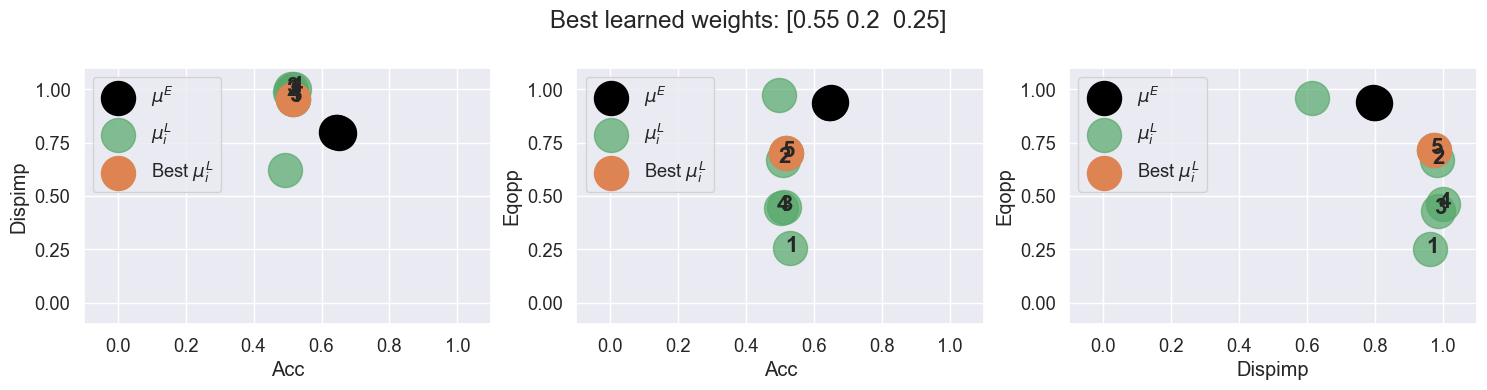

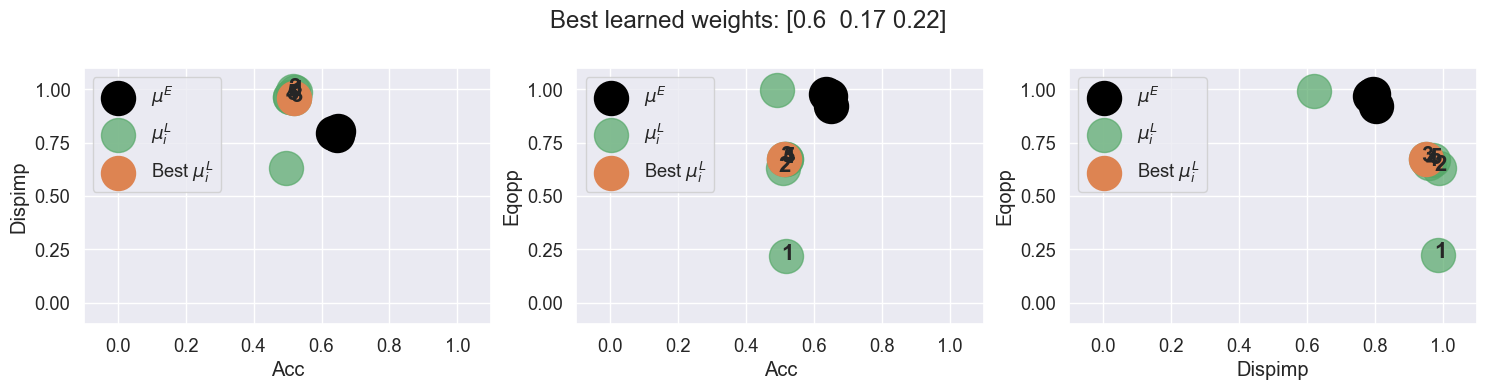

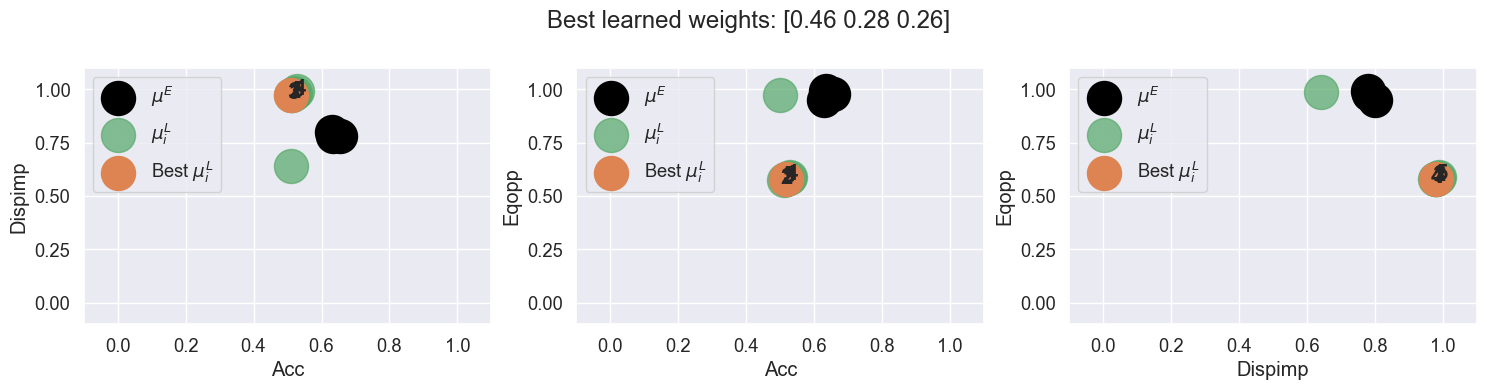

In [75]:
##
# Set aggregation variables
##
results = []
trial_i = 0

##
# Run the experiment trials
##
while trial_i < N_TRIALS:
    logging.info(f"\n\nTRIAL {trial_i}\n")
    ##
    # Reset the objective set since they get fitted in each trial run
    ##
    obj_set.reset()

    ##
    # Read in Adult dataset
    ##

    df, X, y = generate_adult_dataset(n=25_000)
    rus = RandomUnderSampler(sampling_strategy=1)
    X, y = rus.fit_resample(X, y)
    df = X
    df['y'] = y

    # display(df.sample(5))
    # temp = (
    #     df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    #     ['y'].sort_values(['mean', 'count'], ascending=False)
    #     .rename(columns={'mean': 'mean_y'})
    # )
    # display(temp)

    ##
    # Split data into two: (X_demo, y_demo), (X_irl_valid, y_irl_valid). The
    # former is used for generating the expert's demonstrations. The latter is
    # used in the IRL loop for learning the optimal policies for a given reward
    # function.
    ##
    X_demo, X_hold, y_demo, y_irl_valid = train_test_split(X, y, test_size=.5)
    X_irl_valid_train, X_irl_valid_test, y_irl_valid_train, y_irl_valid_test = train_test_split(X_irl_valid, y_irl_valid, test_size=.5)
    del X, y, X_irl_valid, y_irl_valid  # Make sure I don't acidentally use these variables later on


    ##
    # Generate expert demonstrations
    ##
    muE, demosE = generate_demos_k_folds(
        X_demo=X_demo,
        y_demo=y_demo,
        clf=EXPERT_ALGO_LOOKUP[EXPERT_ALGO],
        obj_set=obj_set,
        n_demos=N_EXPERT_DEMOS,
    )
    logging.info(f"muE:\n{muE}")

    ##
    # Run IRL loop.
    # Create a clf dataset where inputs are feature expectations and outputs are
    # whether the policy is expert or learned through IRL iterations. Then train
    # an SVM classifier on this dataset. Then extract the weights of the svm and
    # use them as the weights for the "reward" function. Then use this reward
    # function to learn a policy (classifier). Then compute the feature
    # expectations from this classifer on the irl hold-out set. Then compute the
    # error between the feature expectations of this learned clf and the
    # demonstration feature exp. If this error is less than epsilon, stop. The
    # reward function is the final set of weights.
    ##

    x_cols = (
        irl_loop_feature_types['boolean']
        + irl_loop_feature_types['categoric']
        + irl_loop_feature_types['continuous']
    )
    x_cols.remove('z')
    obj_set_cols = [obj.name for obj in obj_set.objectives]


    # Generate initial learned policies
    mu, _demos = generate_demos_k_folds(
        X_demo=X_demo,
        y_demo=y_demo,
        clf=DummyClassifier(strategy="uniform"),
        obj_set=obj_set,
        n_demos=N_INIT_POLICIES,
    )

    X_irl_exp = pd.DataFrame(muE, columns=obj_set_cols)
    y_irl_exp = pd.Series(np.ones(N_EXPERT_DEMOS), dtype=int)
    X_irl_learn = pd.DataFrame(mu, columns=obj_set_cols)
    y_irl_learn = pd.Series(np.zeros(len(mu)), dtype=int)

    t = []  # Errors for each iteration
    mu_delta_l2norm_hist = []
    weights = []
    i = 0
    demo_history = []
    mu_history = []
    is_random_weight = []

    logging.debug('')
    logging.debug('Starting IRL Loop ...')

    while True:
        logging.info(f"\tIRL Loop iteration {i+1}/{max_iter} ...")

        # Train SVM classifier that distinguishes which demonstrations are expert
        # and which were generated from this loop.
        logging.debug('\tFitting SVM classifier...')
        if SAMPLE_LEARNED_POLICIES and i > 2:
            # TRY SAMPLING FROM LEARNE DPOLICIES TO AVOID LOCAL OPTIMUM ISSUE
            # n_samples_to_use = np.random.randint(low=2, high=len(X_irl_learn)-1)
            n_samples_to_use = 2
            sampled_idx = X_irl_learn.sample(n_samples_to_use).index
            sampled_X_irl_learn = X_irl_learn.loc[sampled_idx].copy()
            sampled_y_irl_learn = y_irl_learn.loc[sampled_idx].copy()
            X_irl = pd.concat([X_irl_exp, sampled_X_irl_learn], axis=0).reset_index(drop=True)
            y_irl = pd.concat([y_irl_exp, sampled_y_irl_learn], axis=0).reset_index(drop=True)
            svm = SVM().fit(X_irl, y_irl)
        else:
            X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
            y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
            svm = SVM().fit(X_irl, y_irl)

        if np.random.rand() < RANDOM_WEIGHT_RATE:
            wi = np.random.rand(len(obj_set.objectives))
            is_random_weight.append(1)
        else:
            # Extract the weights from the SVM classifier. These weights become the
            # reward weights.
            wi = svm.weights()
            is_random_weight.append(0)

        # Trying something out
        if NO_NEG_WEIGHTS:
            for _i, w in enumerate(wi):
                if w < 0:
                    wi[_i] = 0

        weights.append(wi)

        # Learn a policy (clf_pol) from the reward (SVM) weights.
        valid_df = pd.DataFrame(X_demo)
        valid_df['y'] = y_demo

        # Fit a classifier that predicts `y` from `X`.
        logging.debug('\tFitting `y|x` predictor for clf policy...')
        clf = sklearn_clf_pipeline(
            feature_types=irl_loop_feature_types,
            clf_inst=RandomForestClassifier(),
#             clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
        )
        clf.fit(
            X=valid_df.iloc[:, :-1],
            y=valid_df.iloc[:, -1],
        )
        # Learn a policy that maximizes the reward function.
        logging.debug('\tComputing the optimal policy given reward weights and `y|x` classifier...')
        reward_weights = { obj.name: wi[j] for j, obj in enumerate(obj_set.objectives) }
        clf_pol = compute_optimal_policy(
            clf_df=valid_df,
            clf=clf,
            x_cols=x_cols,
            obj_set=obj_set,
            reward_weights=reward_weights,
            skip_error_terms=SKIP_ERROR_TERMS,
            method=METHOD,
        )

        # Compute feature expectations of the learned policy
        logging.debug('\tGenerating learned demostration...')
        demo = generate_demo(clf_pol, X_irl_valid, y_irl_valid, can_observe_y=CAN_OBSERVE_Y)
        demo_history.append(demo)
        muj = obj_set.compute_demo_feature_exp(demo)
        mu_history.append(muj)
        logging.debug(f"\t\t muL[i] = {np.round(muj, 3)}")

        # Append policy's feature expectations to irl clf dataset
        X_irl_learn_i = pd.DataFrame(np.array([muj]), columns=obj_set_cols)
        y_irl_learn_i = pd.Series(np.zeros(1), dtype=int)
        X_irl_learn = pd.concat([X_irl_learn, X_irl_learn_i], axis=0)
        y_irl_learn = pd.concat([y_irl_learn, y_irl_learn_i], axis=0)

        # Compute error of the learned policy: t[i] = wT(muE-mu[j])
        ti, mu_delta, mu_delta_l2norm= irl_error(wi, muE, muj)
        t.append(ti)
        mu_delta_l2norm_hist.append(mu_delta_l2norm)
        logging.debug(f"\t\t mu_delta[i] \t= {np.round(mu_delta, 3)}")
        logging.debug(f"\t\t t[i] \t\t= {t[i]:.5f}")
        logging.debug(f"\t\t weights[{i}] \t= {np.round(weights[i], 3)}")

        # Show a summary of the learned policy
    #     logging.info(
    #         df_to_log(
    #             demo.groupby(['z']+x_cols+['y', 'yhat'])[['age']].agg(['count']),
    #             title='\tLearned Policy:',
    #             tab_level=3,
    #         )
    #     )

        if ti < epsilon or i >= max_iter - 1:
            break

        i += 1


    print('\n'+ 100*'-' + '\n')

    # Compare the best learned policy with the expert demonstrations
    for demo in demosE:
        logging.info(f"Expert demo yhat:\t {demo['yhat'].mean()}")
    #     display(demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean']))

    logging.debug('\n'+ 100*'-' + '\n')

    best_iter = np.argmin(t)
    logging.debug('Best iteration: ' + str(best_iter))
    best_demo = demo_history[best_iter]
    logging.info(f"Best Learned Policy yhat: {best_demo['yhat'].mean():.3f}")
    # display(
    #     best_demo.groupby(['z']+x_cols+['y'])[['yhat']].agg(['count', 'mean'])
    # )
    best_weight = weights[best_iter]
    logging.info(f"best weight:\t {np.round(best_weight, 3)}")

    logging.debug('\n'+ 100*'-' + '\n')
    X_irl = pd.concat([X_irl_exp, X_irl_learn], axis=0).reset_index(drop=True)
    y_irl = pd.concat([y_irl_exp, y_irl_learn], axis=0).reset_index(drop=True)
    df_irl = X_irl.copy()
    df_irl['is_expert'] = y_irl.copy()
    df_irl['is_init_policy'] = np.zeros(N_EXPERT_DEMOS).tolist() + np.ones(N_INIT_POLICIES).tolist() + np.zeros(len(t)).tolist()
    df_irl['learn_idx'] = list(-1*np.ones(N_EXPERT_DEMOS)) + list(np.arange(N_INIT_POLICIES + len(t)))
    df_irl['is_random_weight'] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + is_random_weight
    for i, col in enumerate(obj_set_cols):
        df_irl[f"{col}_weight"] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + [w[i] for w in weights]
    df_irl['t'] = list(np.inf*(np.ones(N_EXPERT_DEMOS+N_INIT_POLICIES))) + t
    df_irl['mu_delta_l2norm'] = np.zeros(N_EXPERT_DEMOS+N_INIT_POLICIES).tolist() + mu_delta_l2norm_hist
    logging.debug('Historical feature expectations')
    display(df_irl)

    ##
    # Plot results
    ##
    sns.set_theme(style='darkgrid', font_scale=1.2)

    feat_exp_combs = list(itertools.combinations(obj_set_cols, 2))

    exp = df_irl.query('is_expert == True').reset_index(drop=True)
    lrn = df_irl.query('is_expert == False and is_random_weight == 0').reset_index(drop=True)
    best_t_idx = lrn.query('t > 0')['t'].argmin()

    fig, axes = plt.subplots(1, len(feat_exp_combs), figsize=(5*len(feat_exp_combs), 4))
    axes = (axes,) if len(feat_exp_combs) == 1 else axes
    for i, (feat_exp_x, feat_exp_y) in enumerate(feat_exp_combs):
        # Plot expert
        axes[i].scatter(exp[feat_exp_x], exp[feat_exp_y], label='$\mu^E$', s=600, alpha=1, c='black')
        # Inject noise so we can see the expert when it's overlapping
        noise = NOISE_FACTOR*(np.random.rand(len(lrn))-.6)
        # Plot the learned policies
        axes[i].scatter(lrn[feat_exp_x]+noise, lrn[feat_exp_y]+noise, label='$\mu^L_i$', s=600, alpha=.7, c=cp[2])
        axes[i].set_ylim([-.1, 1.1])
        axes[i].set_xlim([-.1, 1.1])
        axes[i].set_xlabel(feat_exp_x.replace('_', ' ').title())
        axes[i].set_ylabel(feat_exp_y.replace('_', ' ').title())
        if ANNOTATE:
            # Label each learned policy with its ordered index
            for idx, row in lrn.iterrows():
                if row['is_init_policy']:
                    annotation = None
                else:
                    annotation = idx
                axes[i].annotate(annotation, (-.012+(row[feat_exp_x]+noise[idx]), -.015+(row[feat_exp_y]+noise[idx])), fontsize=16, fontweight=700)
        # Color the best policy
        axes[i].scatter([lrn.loc[best_t_idx][feat_exp_x]+noise[best_t_idx]], [lrn.loc[best_t_idx][feat_exp_y]+noise[best_t_idx]], label='Best $\mu^L_i$', s=600, alpha=1, c=cp[1])
        axes[i].legend(ncol=1, labelspacing=.7, loc='upper left')

    plt.suptitle(f"Best learned weights: {best_weight.round(2)}")
    plt.tight_layout()

    ##
    # Append results
    ##
    results.append(new_trial_result(obj_set, muE, df_irl))
    
    trial_i += 1

In [76]:
##
# Persist trial results
##
exp_df = generate_single_exp_results_df(obj_set, results)
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
exp_df.to_csv(f"./../../data/experiment_output/fair_irl/trial_results/{timestamp}.csv")

##
# Persist trial info
##
import json
trial_info['timestamp'] = timestamp
fp = f"./../../data/experiment_output/fair_irl/trial_info/{timestamp}.json"
json.dump(trial_info, open(fp, 'w'))

# Compare results

In [81]:
def compare_results(expert_algo):
    # Construct a pivot table so we can do a seaborn boxplot
    mu_cols = ['Value', 'Demo Producer', 'Feature Expectation']
    mu_rows = []
    w_cols = ['Value', 'IRL Method', 'Weight']
    w_rows = []

    path_prefix = './../../data/experiment_output/fair_irl/'
    trial_results_files = os.listdir(f"{path_prefix}/trial_results/")
    trial_info_files = os.listdir(f"{path_prefix}/trial_info/")

    # For each experiment...
    for (result_file, info_file) in zip(trial_results_files, trial_info_files):
        result = pd.read_csv(f"{path_prefix}/trial_results/{result_file}")
        info = json.load(open(f"{path_prefix}/trial_info/{info_file}"))
        
        # Filter to only experiments for the input `expert_algo`
        if info['EXPERT_ALGO'] != expert_algo:
            continue

        for idx, row in result.iterrows():
            # Append muE and muL results
            for obj_name in info['objective_names']:
                mu_rows.append([row[f"muE_{obj_name}_mean"], 'muE', obj_name])
            for obj_name in info['objective_names']:
                mu_rows.append([row[f"muL_{obj_name}"], f"muL ({info['IRL_METHOD']})", obj_name])
                w_rows.append([row[f"wL_{obj_name}"], f"wL ({info['IRL_METHOD']})", obj_name])

    if len(mu_rows) == 0:
        raise ValueError(f"No experimets with EXPERT_ALGO={expert_algo}")
    mu_df = pd.DataFrame(mu_rows, columns=mu_cols)
    w_df = pd.DataFrame(w_rows, columns=w_cols)

    # Plot boxplot for feature expectations
    fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    sns.boxplot(
        x=mu_df['Feature Expectation'],
        y=mu_df['Value'],
        hue=mu_df['Demo Producer'],
        ax=ax1,
        fliersize=0,  # Remove outliers
    )
    ax1.set_title(f"{expert_algo}")

    # Plot boxplot for weights
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    sns.boxplot(
        x=w_df['Weight'],
        y=w_df['Value'],
        hue=w_df['IRL Method'],
        ax=ax2,
        fliersize=0,  # Remove outliers
        palette=cp[1:],
    )
    ax2.set_title(f"{expert_algo}")
    
    return mu_df, w_df

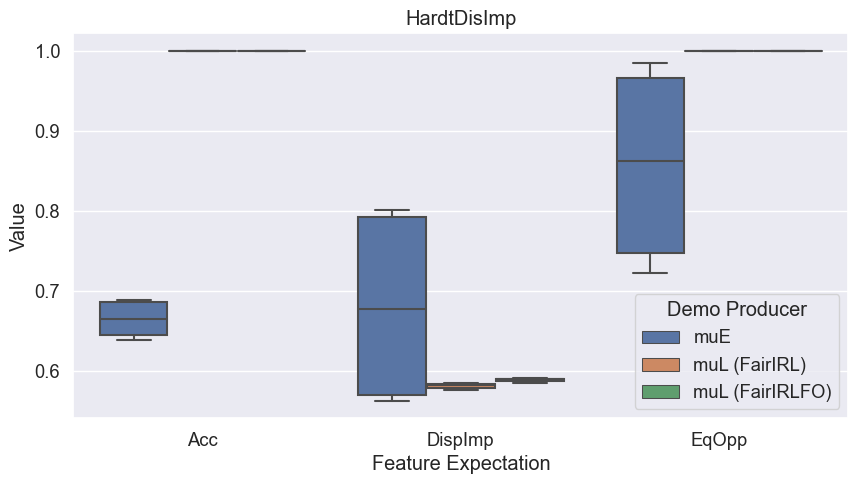

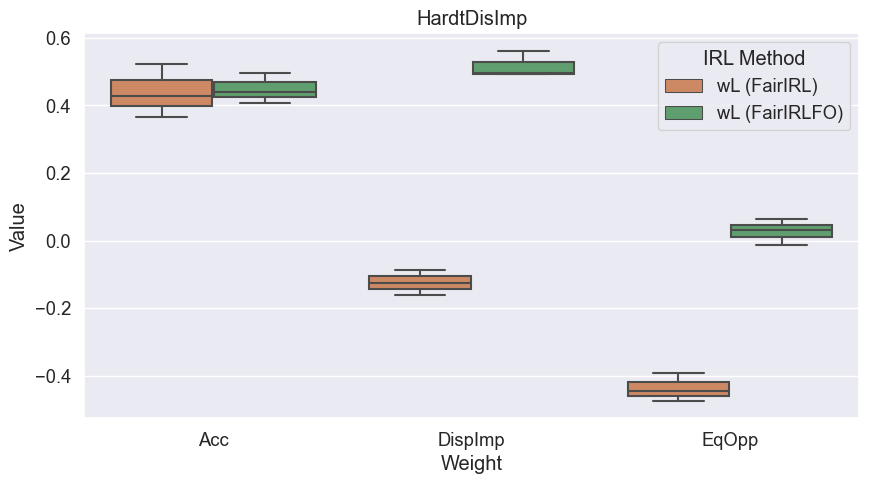

In [82]:
mu_df, w_df = compare_results('HardtDisImp')

In [83]:
mu_df

,Value,Demo Producer,Feature Expectation
0,0.688582,muE,Acc
1,0.563399,muE,DispImp
2,0.779512,muE,EqOpp
3,1.000000,muL (FairIRL),Acc
4,0.577020,muL (FairIRL),DispImp
5,1.000000,muL (FairIRL),EqOpp
6,0.688941,muE,Acc
7,0.579354,muE,DispImp
8,0.722314,muE,EqOpp
9,1.000000,muL (FairIRL),Acc


In [161]:
results_summary = {
    'n_trials': N_TRIALS,
    'data_demo':'Adult',
    'exp_algo': EXPERT_ALGO,
    'irl_method': IRL_METHOD,
}

for obj in obj_set.objectives:
    results_summary[f"wL_{obj.name}_mean"] = np.round(np.mean(exp_df[f"wL_{obj.name}"]), 3)
    results_summary[f"wL_{obj.name}_std"] = np.round(np.std(exp_df[f"wL_{obj.name}"]), 3)
    
for obj in obj_set.objectives:
    results_summary[f"muE_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muE_{obj.name}_mean"]), 3)
    results_summary[f"muE_{obj.name}_std"] = np.round(np.mean(exp_df[f"muE_{obj.name}_std"]), 3)

for obj in obj_set.objectives:
    results_summary[f"muL_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muL_{obj.name}"]), 3)
    results_summary[f"muL_{obj.name}_std"] = np.round(np.std(exp_df[f"muL_{obj.name}"]), 3)
    
for obj in obj_set.objectives:
    results_summary[f"muL_err_{obj.name}_mean"] = np.round(np.mean(exp_df[f"muL_err_{obj.name}"]), 3)
    results_summary[f"muL_err_{obj.name}_std"] = np.round(np.std(exp_df[f"muL_err_{obj.name}"]), 3)

results_summary['muL_err_l2norm_mean'] = np.round(np.mean(exp_df['muL_err_l2norm']), 3)
results_summary['muL_err_l2norm_std'] = np.round(np.std(exp_df['muL_err_l2norm']), 3)


results_summary

{'n_trials': 3,
 'data_demo': 'Adult',
 'exp_algo': 'disp_imp_reduction',
 'irl_method': 'FairIRL',
 'wL_Acc_mean': 0.698,
 'wL_Acc_std': 0.121,
 'wL_DispImp_mean': 0.165,
 'wL_DispImp_std': 0.036,
 'wL_EqOpp_mean': 0.137,
 'wL_EqOpp_std': 0.094,
 'muE_Acc_mean': 0.645,
 'muE_Acc_std': 0.007,
 'muE_DispImp_mean': 0.771,
 'muE_DispImp_std': 0.028,
 'muE_EqOpp_mean': 0.956,
 'muE_EqOpp_std': 0.032,
 'muL_Acc_mean': 0.573,
 'muL_Acc_std': 0.082,
 'muL_DispImp_mean': 0.823,
 'muL_DispImp_std': 0.181,
 'muL_EqOpp_mean': 0.667,
 'muL_EqOpp_std': 0.034,
 'muL_err_Acc_mean': 0.105,
 'muL_err_Acc_std': 0.039,
 'muL_err_DispImp_mean': 0.156,
 'muL_err_DispImp_std': 0.002,
 'muL_err_EqOpp_mean': 0.29,
 'muL_err_EqOpp_std': 0.02,
 'muL_err_l2norm_mean': 0.347,
 'muL_err_l2norm_std': 0.027}

In [168]:
all_results_as_dicts = [
{'n_trials': 5,
 'data_demo': 'Adult',
 'exp_algo': 'disp_imp_reduction',
 'irl_method': 'ClfIRL',
 'wL_Acc_mean': 0.612,
 'wL_Acc_std': 0.163,
 'wL_DispImp_mean': 0.192,
 'wL_DispImp_std': 0.12,
 'wL_EqOpp_mean': 0.087,
 'wL_EqOpp_std': 0.188,
 'muE_Acc_mean': 0.649,
 'muE_Acc_std': 0.008,
 'muE_DispImp_mean': 0.765,
 'muE_DispImp_std': 0.044,
 'muE_EqOpp_mean': 0.959,
 'muE_EqOpp_std': 0.023,
 'muL_Acc_mean': 0.588,
 'muL_Acc_std': 0.083,
 'muL_DispImp_mean': 0.82,
 'muL_DispImp_std': 0.203,
 'muL_EqOpp_mean': 0.694,
 'muL_EqOpp_std': 0.084,
 'muL_err_Acc_mean': 0.093,
 'muL_err_Acc_std': 0.045,
 'muL_err_DispImp_mean': 0.177,
 'muL_err_DispImp_std': 0.025,
 'muL_err_EqOpp_mean': 0.265,
 'muL_err_EqOpp_std': 0.09,
 'muL_err_l2norm_mean': 0.336,
 'muL_err_l2norm_std': 0.09,
},
{'n_trials': 10,
 'data_demo': 'Adult',
 'exp_algo': 'optimize_accuracy',
 'irl_method': 'ClfIRLFO',
 'wL_Acc_mean': 0.181,
 'wL_Acc_std': 0.341,
 'wL_DispImp_mean': -0.308,
 'wL_DispImp_std': 0.359,
 'wL_EqOpp_mean': -0.09,
 'wL_EqOpp_std': 0.381,
 'muE_Acc_mean': 0.689,
 'muE_Acc_std': 0.005,
 'muE_DispImp_mean': 0.626,
 'muE_DispImp_std': 0.025,
 'muE_EqOpp_mean': 0.959,
 'muE_EqOpp_std': 0.023,
 'muL_Acc_mean': 1.0,
 'muL_Acc_std': 0.0,
 'muL_DispImp_mean': 0.597,
 'muL_DispImp_std': 0.008,
 'muL_EqOpp_mean': 1.0,
 'muL_EqOpp_std': 0.0,
 'muL_err_Acc_mean': 0.311,
 'muL_err_Acc_std': 0.005,
 'muL_err_DispImp_mean': 0.03,
 'muL_err_DispImp_std': 0.046,
 'muL_err_EqOpp_mean': 0.041,
 'muL_err_EqOpp_std': 0.015,
 'muL_err_l2norm_mean': 0.319,
 'muL_err_l2norm_std': 0.012,
},
{'n_trials': 50,
 'data_demo': 'Adult',
 'exp_algo': 'optimize_accuracy',
 'irl_method': 'ClfIRL',
 'wL_Acc_mean': 0.772,
 'wL_Acc_std': 0.158,
 'wL_DispImp_mean': -0.017,
 'wL_DispImp_std': 0.132,
 'wL_EqOpp_mean': 0.08,
 'wL_EqOpp_std': 0.152,
 'muE_Acc_mean': 0.686,
 'muE_Acc_std': 0.007,
 'muE_DispImp_mean': 0.62,
 'muE_DispImp_std': 0.025,
 'muE_EqOpp_mean': 0.955,
 'muE_EqOpp_std': 0.026,
 'muL_Acc_mean': 0.854,
 'muL_Acc_std': 0.192,
 'muL_DispImp_mean': 0.727,
 'muL_DispImp_std': 0.188,
 'muL_EqOpp_mean': 0.67,
 'muL_EqOpp_std': 0.351,
 'muL_err_Acc_mean': 0.234,
 'muL_err_Acc_std': 0.099,
 'muL_err_DispImp_mean': 0.147,
 'muL_err_DispImp_std': 0.163,
 'muL_err_EqOpp_mean': 0.289,
 'muL_err_EqOpp_std': 0.349,
 'muL_err_l2norm_mean': 0.498,
 'muL_err_l2norm_std': 0.263,
}
]


In [171]:
all_results = pd.DataFrame(columns=all_results_as_dicts[0].keys())
for k in all_results_as_dicts[0].keys():
    series = []
    for d in all_results_as_dicts:
        series.append(d[k])
    all_results[k] = series
all_results

,n_trials,data_demo,exp_algo,irl_method,wL_Acc_mean,wL_Acc_std,wL_DispImp_mean,wL_DispImp_std,wL_EqOpp_mean,wL_EqOpp_std,...,muL_EqOpp_mean,muL_EqOpp_std,muL_err_Acc_mean,muL_err_Acc_std,muL_err_DispImp_mean,muL_err_DispImp_std,muL_err_EqOpp_mean,muL_err_EqOpp_std,muL_err_l2norm_mean,muL_err_l2norm_std
0,5,Adult,disp_imp_reduction,ClfIRL,0.612,0.163,0.192,0.120,0.087,0.188,...,0.694,0.084,0.093,0.045,0.177,0.025,0.265,0.090,0.336,0.090
1,10,Adult,optimize_accuracy,ClfIRLFO,0.181,0.341,-0.308,0.359,-0.090,0.381,...,1.000,0.000,0.311,0.005,0.030,0.046,0.041,0.015,0.319,0.012
2,50,Adult,optimize_accuracy,ClfIRL,0.772,0.158,-0.017,0.132,0.080,0.152,...,0.670,0.351,0.234,0.099,0.147,0.163,0.289,0.349,0.498,0.263


In [ ]:
import matplotlib.pyplot as plt


fs = 10  # fontsize

stats = []
for i in range(0, 3):
    stats.append({
    "label": str(i+1),  # not required
    "mean":  5,  # not required
    "med": (i+1)*5.5,
    "q1": (i+1)*3.5,
    "q3": (i+1)*7.5,
    # "cilo": 5.3 # not required
    # "cihi": 5.7 # not required
    "whislo": 2.0,  # required
    "whishi": 8.0,  # required
    "fliers": []  # required if showfliers=True
    })

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
bplot = axes.bxp(stats, patch_artist=True)
axes.set_title('Boxplot for precalculated statistics', fontsize=fs)

# fill with colors
for patch, color in zip(bplot['boxes'], cp[0:3]):
    patch.set_facecolor(color)

# Use learned rewards on Adult to predict on Compas dataset

In [310]:
# _df = pd.read_csv('./../../data/compas-scores-raw.csv')
# _df = pd.read_csv('./../../data/compas/propublica_data_for_fairml.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed_filt.csv')
# _df = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')
compas = pd.read_csv('./../../data/compas/cox-violent-parsed.csv')

In [311]:
df, X, y = generate_compas_dataset(
    filepath='./../../data/compas/cox-violent-parsed.csv',
    n=10_000,
)

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)
rus = RandomUnderSampler(sampling_strategy=1)
X, y = rus.fit_resample(X, y)
df = X
df['y'] = y

display(
    df.groupby(['z', 'gender'])[['y']].agg(['count', 'mean'])
    ['y'].sort_values(['mean', 'count'], ascending=False)
    .rename(columns={'mean': 'mean_y'})
)

INFO:root:Dataset count of each z, y group
INFO:root:
	      y          
	  count      mean
	z                
	0  6400  0.503906
	1  3164  0.421302



count    mean_y
z gender                 
0 Male     5424  0.530420
1 Male     2409  0.432130
  Female    755  0.386755
0 Female    976  0.356557

count    mean_y
z gender                 
0 Male     5205  0.552738
1 Male     2280  0.456579
  Female    713  0.409537
0 Female    918  0.379085

In [340]:
##
# These are the feature types that will be used in the classifier that is
# learned in the target domain and optimizes the weights learned from the
# source domain.
##
target_feature_types = {
    'boolean': [
        'z',
        'gender',
    ],
    'categoric': [
        'score_text',
    ],
    'continuous': [
#         'priors_count',
    ],
    'meta': [
    ],
}
x_cols = (
    target_feature_types['boolean']
    + target_feature_types['categoric']
    + target_feature_types['continuous']
)
x_cols.remove('z')

In [342]:
logging.info(f"Adult dataset learned weights: {np.round(best_weight, 3)}")

logging.info('\n\n'+ 100*'-' + '\n')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)
train_df = pd.DataFrame(X_train)
train_df['y'] = y_train
# Fit a classifier that predicts `y` from `X`.
rf = RandomForestClassifier()
logging.info('\tFitting `y|x` predictor for clf policy...')
# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=rf,
    x_cols=x_cols,
    acc_weight=best_weight[0],
    disp_imp_weight=best_weight[1],
)

# Compute feature expectations of the learned policy
logging.info('\tGenerating learned demonstration...')
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of learned policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of learned policy: {muj[1]:.2f}")

    
logging.info('\n\n'+ 100*'-' + '\n')

INFO:root:Adult dataset learned weights: [0.952 0.048]
INFO:root:

----------------------------------------------------------------------------------------------------

INFO:root:	Fitting `y|x` predictor for clf policy...
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	Generating learned demonstration...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of learned policy: 0.62
INFO:root:Disp Imp of learned policy: 0.76
INFO:root:

----------------------------------------------------------------------------------------------------



In [343]:
ORIGINAL_WEIGHTS = [1, 0]
logging.info('\tGenerating demonstration of the exact policy used on the original adult dataset')

# clf_inst = ManualClassifier(lambda_female)
# demo = generate_demo(clf_inst, X_test, y_test)
# muj = compute_demo_feature_exp(demo)
# logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
# logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

# Learn a policy that maximizes the reward function.
logging.info('\tComputing the optimal policy given reward weights and `y|x` classifier...')
clf_inst = RandomForestClassifier()
clf_pol = compute_optimal_policy(
    clf_df=train_df,
    feature_types=target_feature_types,
    clf_inst=clf_inst,
    x_cols=x_cols,
    acc_weight=ORIGINAL_WEIGHTS[0],
    disp_imp_weight=ORIGINAL_WEIGHTS[1],
)
demo = generate_demo(clf_pol, X_test, y_test)
muj = compute_demo_feature_exp(demo)
logging.info(f"Accuracy of explicit policy: {muj[0]:.2f}")
logging.info(f"Disp Imp of explicit policy: {muj[1]:.2f}")

INFO:root:	Generating demonstration of the exact policy used on the original adult dataset
INFO:root:	Computing the optimal policy given reward weights and `y|x` classifier...
INFO:root:		Checking if classifier already fitted...
INFO:root:		Fitting classifier...
INFO:root:	State Lookup Error: ('Male', nan, 1, 1)
INFO:root:	Using default action: 0
INFO:root:Accuracy of explicit policy: 0.62
INFO:root:Disp Imp of explicit policy: 0.76


# Other Notes

### Notes and Assumptions

* Meaning of `fnlwgt` column: it is the (estimated) number of people each row in the data represents. I'm removing it for now. Although we may want to consider resampling each row based on its `fnlwgt` value. See what other papers do with this column.
* There are 5 possible values for `race`. I'm going to make it binary with `White` vs `Non-White`. Gender only has male and female so leaving this as is.

# FairLearn quickstart

In [34]:
from fairlearn.datasets import fetch_adult
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Male      32650
Female    16192
Name: sex, dtype: int64

In [49]:
from fairlearn.metrics import *
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
display(mf.overall)
display(mf.by_group)

0.8443552680070431

sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: float64

In [50]:
sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
display(sr.overall)
display(sr.by_group)

0.16385487899758405

sex
Female    0.063550
Male      0.213599
Name: selection_rate, dtype: float64

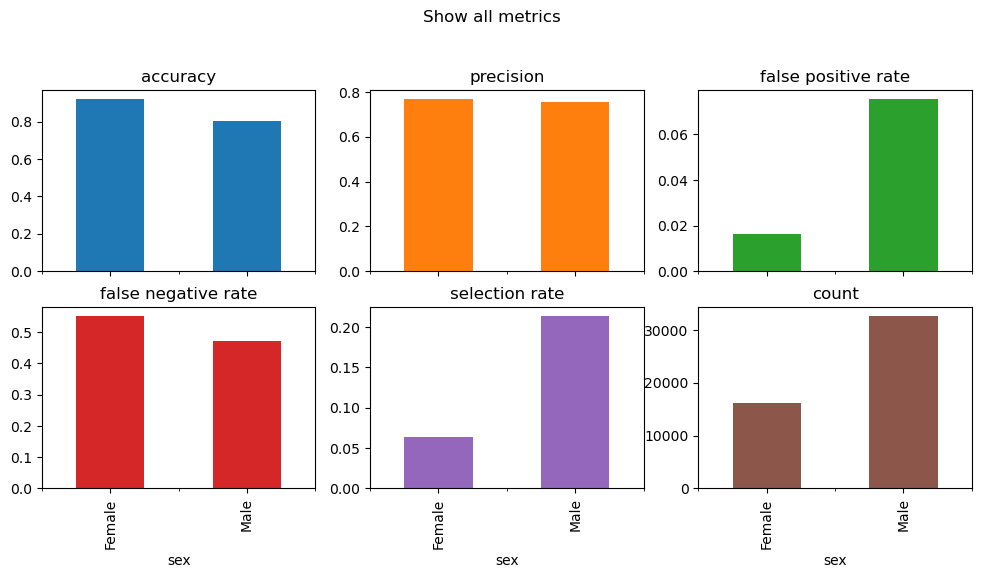

In [53]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)
pass

In [55]:
##
# Mitigate disparate impact (selection rate)
##

from fairlearn.reductions import DemographicParity, ExponentiatedGradient
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
sr_mitigated.overall

sr_mitigated.by_group

sex
Female    0.155262
Male      0.171547
Name: selection_rate, dtype: float64

In [74]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
data.data['z'] = (data.data['race'] == 'White').astype(int)
data.target = (data.target == '>50K').astype(int)

In [97]:
pipe = sklearn_clf_pipeline(
    feature_types=expert_demo_feature_types,
#     clf_inst=RandomForestClassifier(),
    clf_inst=DecisionTreeClassifier(min_samples_leaf=10, max_depth=4),
)

dem_par_clf = ThresholdOptimizer(
    estimator=pipe,
#     constraints="demographic_parity",
    constraints='demographic_parity',
    predict_method="predict",
    prefit=False,
)
# dem_par_clf = ExponentiatedGradient(pipe, DemographicParity())
dem_par_reduction = ReductionWrapper(
    clf=dem_par_clf,
    sensitive_features='z',
)
dem_par_reduction.fit(data.data, data.target)




In [99]:
y_pred_mitigated = dem_par_reduction.predict(data.data)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=data.target, y_pred=y_pred_mitigated, sensitive_features=data.data['z'])

display(sr_mitigated.overall)
display(sr_mitigated.by_group)

0.06410466401867246

z
0    0.065678
1    0.063838
Name: selection_rate, dtype: float64

In [2]:
from tempeh.configurations import datasets

compas_dataset = datasets["compas"]()
X_train, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train, y_test = compas_dataset.get_y(format=pd.Series)
(
    sensitive_features_train,
    sensitive_features_test,
) = compas_dataset.get_sensitive_features("race", format=pd.Series)
X_train.loc[0], y_train[0]


ModuleNotFoundError: No module named 'tempeh'